In [1]:
import tensorflow as tf
import os
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import PIL
import numpy as np

In [2]:

def load(image_file):
    input_image = tf.io.read_file("dataset/skeletons/" + image_file)
    real_image = tf.io.read_file("dataset/animal/" + image_file)
    if image_file.endswith(".jpg"):
        input_image = tf.image.decode_jpeg(input_image)
        real_image = tf.image.decode_jpeg(real_image)
    else:
        input_image = tf.image.decode_png(input_image)
        real_image = tf.image.decode_png(real_image)

    input_image = tf.image.resize(input_image, (256, 256))
    real_image = tf.image.resize(real_image, (256, 256))

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

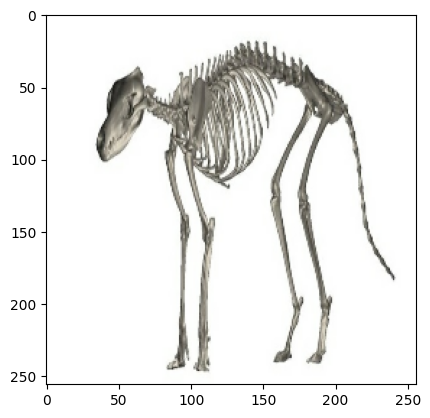

In [3]:

img, real = load("1.jpg")
plt.figure()
plt.imshow(img/255.0)
plt.show()

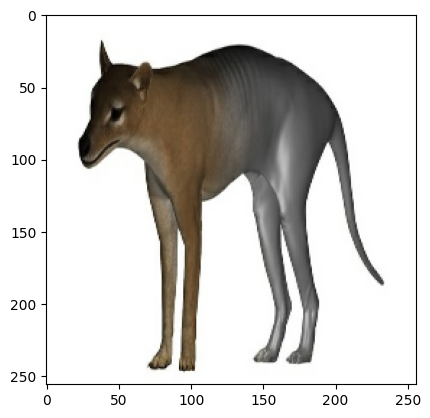

In [4]:
plt.figure()
plt.imshow(real/255.0)
plt.show()

In [5]:
# The facade training set consist of 500 images
BUFFER_SIZE = 500
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

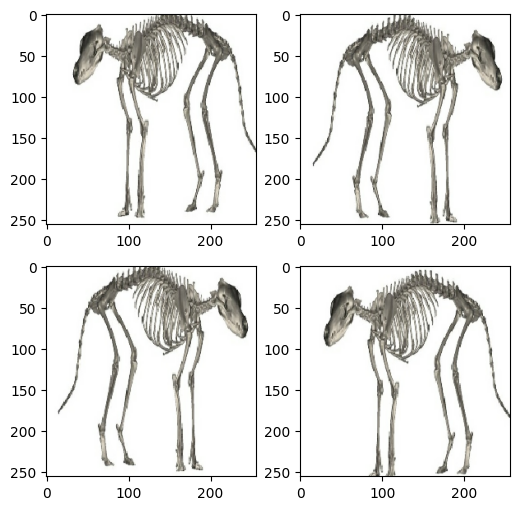

In [10]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(img, real)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('on')
plt.show()

In [11]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [12]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(str('dataset/skeletons/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

AttributeError: in user code:

    File "/var/folders/hl/t7z2ty39543bkmkmkphsh1c00000gn/T/ipykernel_29391/288702190.py", line 2, in load_image_train  *
        input_image, real_image = load(image_file)
    File "/var/folders/hl/t7z2ty39543bkmkmkphsh1c00000gn/T/ipykernel_29391/3302937642.py", line 4, in load  *
        if image_file.endswith(".jpg"):

    AttributeError: 'SymbolicTensor' object has no attribute 'endswith'


In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files('dataset/animal/*.jpg')
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files('dataset/val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)